# Model Assessor

Demo an analysis pipeline from start to finish.

In [1]:
import xarray as xr
import ocean_data_gateway as odg
import cf_xarray
import pandas as pd
import extract_model as em
import ocean_model_skill_assessor as omsa
import numpy as np
import requests
import ast

In [2]:
# Set up custom vocabulary to be able to refer to variables in xarray Datasets by my selected names
my_custom_criteria_gist = "https://gist.githubusercontent.com/kthyng/c3cc27de6b4449e1776ce79215d5e732/raw/85dae06cd72c3bb490557b83f799f9cc1b6afbf8/my_custom_criteria.py"
response = requests.get(my_custom_criteria_gist)
my_custom_criteria = ast.literal_eval(response.text)
cf_xarray.set_options(custom_criteria=my_custom_criteria)

In [3]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
# client

## Read in model output

This sample ROMS output has multiple time steps so we can compare with a dataset over time.

In [5]:
url = 'https://gcoos5.geos.tamu.edu/thredds/dodsC/NcML/nowcast_agg.nc'
# url = 'http://barataria.geos.tamu.edu/thredds/dodsC/NcML/forecast_his_archive_agg.nc'
dsm = xr.open_dataset(url, chunks={'ocean_time': 1})

# add more cf-xarray info
dsm = dsm.cf.guess_coord_axis()


Set up data search by region based on where the model output is in space and time. Just get 2 days' worth centered around the mean time of the model output.

In [6]:
deltaT = pd.Timedelta('1 days')
meanT = pd.Timestamp(dsm.cf['T'].mean().values)


kw = {
    "min_lon": float(dsm.cf['u'].cf['longitude'].min()),
    "max_lon": float(dsm.cf['u'].cf['longitude'].max()),
    "min_lat": float(dsm.cf['u'].cf['latitude'].min()),
    "max_lat": float(dsm.cf['u'].cf['latitude'].max()),
    "min_time": meanT - deltaT,
    "max_time": meanT + deltaT,
}

Some basic processing for model time indices:

In [7]:
# drop duplicate time indices if present
# also limit the time range of the model output to what we are requesting from the data to 
# not waste extra time on the model interpolation
# https://stackoverflow.com/questions/51058379/drop-duplicate-times-in-xarray
_, index = np.unique(dsm.cf['T'], return_index=True)
dsm = dsm.cf.isel(T=index).cf.sel(T=slice(kw['min_time'], kw['max_time']))

## Search for data 

Next find the data that fits the search criteria we set up plus a few more items. We will do a search by region and in this case are specifically using the IOOS ERDDAP server to look for data. Additionally, we are looking specifically sea surface height data with a particular variable name.

In [8]:
kwargs = {
          'kw': kw,
          'approach': 'region',
          'parallel': False,
          'readers': [odg.erddap],
#                       odg.axds],

          'erddap': {
                          'known_server': ['ioos'],
                           'variables': [
#                                          ['sea_water_practical_salinity']]
#                                          ['salinity','sea_water_practical_salinity']
#                                        ['water_surface_height_above_reference_datum_geoid_localstationdatum',
#                                        'sea_surface_height_amplitude_due_to_geocentric_ocean_tide_geoid_mllw',
                                       ['sea_surface_height_above_sea_level_geoid_mllw']
                           ]
          },
#           'axds': {
#                           'axds_type': ['platform2'],
#                          'variables': ['Salinity']},
}


data = odg.Gateway(**kwargs)

Look at a few of the `dataset_id`s that were found:

In [12]:
for i, dataset_ids in enumerate(data.dataset_ids):
    print(i, dataset_ids[:2])

0 ['noaa_nos_co_ops_8732828', 'noaa_nos_co_ops_8775870']


In [9]:

# data.qc(dataset_ids=[['noaa_nos_co_ops_8770822']])
# data.qc(dataset_ids=[['noaa_nos_co_ops_8775870']])
# data.qc(dataset_ids=[['noaa_nos_co_ops_8775870','noaa_nos_co_ops_8773259']])
# data.qc(dataset_ids=[[],
#                      [],
#                      [],
#                      ['05113e8c-ea25-11e0-a998-0019b9dae22b']])
# data.qc()

# For each dataset:

This part of the notebook demonstrates the process for comparing each dataset with the model output.

## Pull out the dataset

For demo purposes, select one dataset by `dataset_id` to compare with the data. We are able to use the syntax `.cf['ssh']` to refer to the sea surface height variable in the dataset due to the custom vocabulary we defined at the top of this notebook for use with `cf-xarray`.

In [14]:
data.data[0]('noaa_nos_co_ops_8770822').cf['ssh'].head()

<xarray.DataArray 'sea_surface_height_above_sea_level_geoid_mllw' (time: 5, timeseries: 1)>
array([[0.645],
       [0.639],
       [0.637],
       [0.628],
       [0.511]])
Coordinates:
  * time       (time) datetime64[ns] 2021-07-17T18:00:00 ... 2021-07-17T18:24:00
    latitude   (timeseries) float64 ...
    longitude  (timeseries) float64 ...
Dimensions without coordinates: timeseries
Attributes:
    actual_range:       [-0.669  3.769]
    id:                 546976
    ioos_category:      Other
    long_name:          Water Level
    platform:           station
    standard_name:      sea_surface_height_above_sea_level
    standard_name_url:  http://mmisw.org/ont/cf/parameter/sea_surface_height_...
    units:              m
    vertical_datum:     MLLW

## Run QC

Run basic quality assessment on the selected dataset. Using the keyword `verbose=True` spits out a simple summary of the flags.

In [15]:
obs = data.qc(dataset_ids=[['noaa_nos_co_ops_8770822']], verbose=True)[0]['noaa_nos_co_ops_8770822']

noaa_nos_co_ops_8770822
sea_surface_height_above_sea_level_geoid_mllw_qc
Flag == 4 (FAIL): 0
Flag == 1 (GOOD): 480
Flag == 9 (MISSING): 7
Flag == 3 (SUSPECT): 0
Flag == 2 (UNKNOWN): 0


In [16]:
obs

<xarray.Dataset>
Dimensions:                                           (time: 487, timeseries: 1)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
    latitude                                          (timeseries) float64 29.68
    longitude                                         (timeseries) float64 -9...
Dimensions without coordinates: timeseries
Data variables:
    sea_surface_height_above_sea_level_geoid_mllw     (time, timeseries) float64 ...
    sea_surface_height_above_sea_level_geoid_mllw_qc  (time, timeseries) uint8 ...
Attributes: (12/53)
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             None,feedback@axiomdatascience.com
    contributor_name:              Gulf of Mexico Coastal Ocean Observing Sys...
    contributor_role:              funder,processor
    contributor_role_vocabulary:   NERC
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v72
    summary:                       Timeseries data from 'Texas Point, Sabine ...
    time_coverage_end:             2021-08-11T17:30:00Z
    time_coverage_start:           2015-09-03T15:42:00Z
    title:                         Texas Point, Sabine Pass
    Westernmost_Easting:           -93.8369

## Extract model output to match data

Extract the model output at the longitude and latitude of the dataset, which has a single location and time series data. Also just extract the sea surface height variable from the model. The result is called `model`.

In [17]:
# data locations to calculate model at
lon = float(obs.cf['longitude'])
lat = float(obs.cf['latitude'])
T = None
# only compare surface
Z = None

kwargs = dict(ds=dsm.cf.isel(Z=0), longitude=lon, latitude=lat, T=T, iZ=Z, varname='ssh', locstream=True)

model = em.select(**kwargs).to_dataset()
model

<xarray.Dataset>
Dimensions:     (locations: 1, ocean_time: 48)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2021-07-17T18:00:00 ... 2021-07-1...
    lon         (locations) float64 -93.84
    lat         (locations) float64 29.68
Dimensions without coordinates: locations
Data variables:
    zeta        (ocean_time, locations) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

## Run statistics comparing model and data

Compare model (`model.cf['ssh']`) and data (`obs.cf['ssh']`) with a suite of statistics.

In [18]:
# Combine and align the two time series of ssh
df = omsa.stats._align(obs.cf['ssh'], model.cf['ssh'])
df.head()

,obs,model
ocean_time,,
2021-07-17 18:00:00,0.645,0.009128
2021-07-17 19:00:00,0.557,0.017717
2021-07-17 20:00:00,0.444,0.028281
2021-07-17 21:00:00,0.400,0.038283
2021-07-17 22:00:00,0.432,0.045895


In [19]:
%%time
df.omsa.compute_stats

CPU times: user 6.33 ms, sys: 717 µs, total: 7.05 ms
Wall time: 6.53 ms


{'bias': -0.6088185796949771,
 'corr': -0.06093768170772346,
 'ioa': 0.24714492394769239,
 'mse': 0.3981184509926054,
 'mss': -20.0081116694725,
 'rmse': 0.6309662835624463,
 'descriptive': (0.12464313587500041,
  -0.1891247073076486,
  0.0002647536383563112,
  0.08422903151068091)}

## Plots

<AxesSubplot:xlabel='ocean_time'>

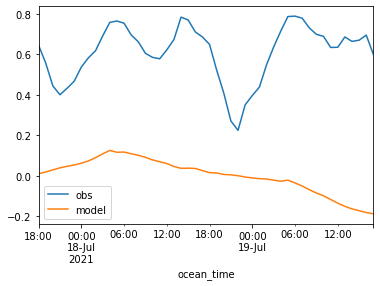

In [20]:
df.plot()

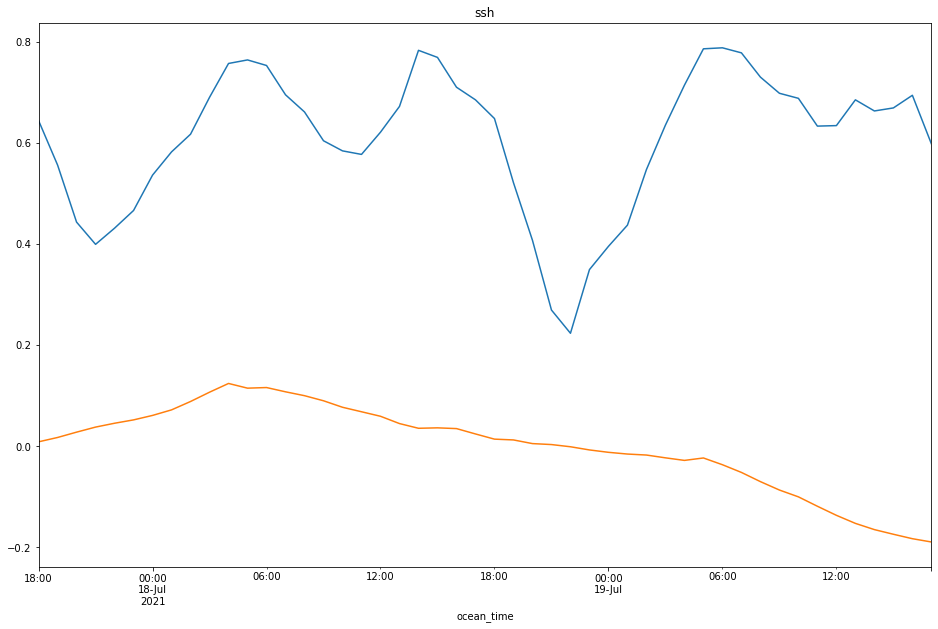

In [21]:
df.omsa.plot('ssh')